In [1]:
#in this script we will train a classifier on mnist and then test it on usps
#we will use the same classifier for both datasets
#classifier is Resnet-50 based on the paper "Deep Residual Learning for Image Recognition"

In [2]:
#in this script we will build a classifier for mnist dataset
#we will use pretraiined Resnet-50 model and train it on mnist dataset

In [3]:
#imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import time
import copy
import torchvision.models as models
import torch.utils.model_zoo as model_zoo
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
import pandas as pd
import random
import math
import torch.nn.init as init
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [4]:
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.io import read_image
from torchsummary import summary

In [7]:
#GPU name
#
GPU_NAME = 'cuda:0'

In [8]:
#device
device = torch.device(GPU_NAME if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
#defining the hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 10
IMAGE_SIZE = 224
CHANNELS_IMG = 3
NUM_CLASSES = 10


In [11]:
#test image path
#here we have one image for just testing in between prototyping
test_img_path = 'test_img.jpg'
load_test_img = read_image(test_img_path)

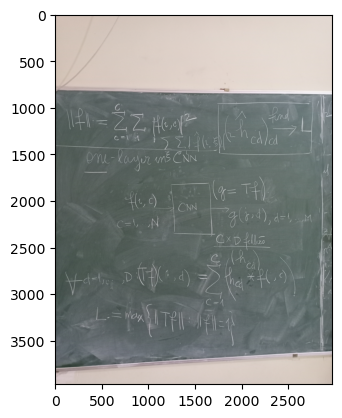

torch.Size([3, 3968, 2976])


In [17]:
#plot the image
plt.imshow(load_test_img.permute(1, 2, 0))
plt.show()

#print the dimensions of the image
print(load_test_img.shape)


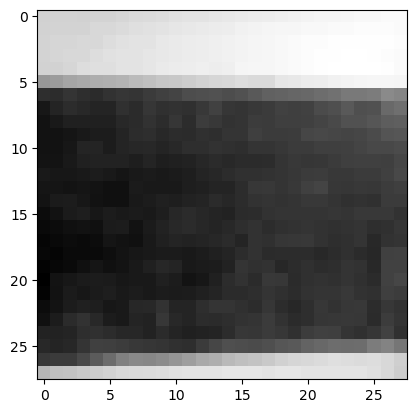

In [23]:
#convert the image to grayscale and then resize it to 28x28 in order to match the mnist dataset
#load input image as PIL image
input_image = Image.open(test_img_path)
gray_img = transforms.functional.to_grayscale(input_image, num_output_channels=1)

#resize the image to 28x28
resized_img = transforms.functional.resize(gray_img, (28, 28))

#plot the image, it is grey scale
plt.imshow(resized_img, cmap='gray')
plt.show()

#save the image
resized_img.save('resized_img.jpg')


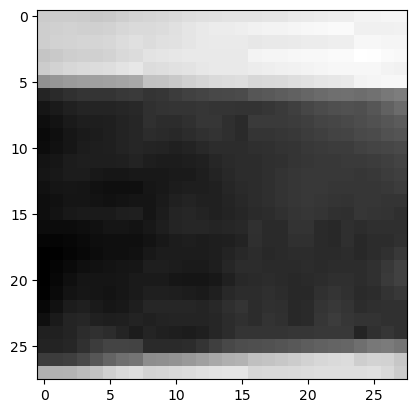

torch.Size([1, 28, 28])


In [28]:
#input the image resized_img.jpg as temp_img
temp_img = read_image('resized_img.jpg')

#show as greyscale
plt.imshow(temp_img.permute(1, 2, 0), cmap='gray')
plt.show()

#print the dimensions of the image
print(temp_img.shape)

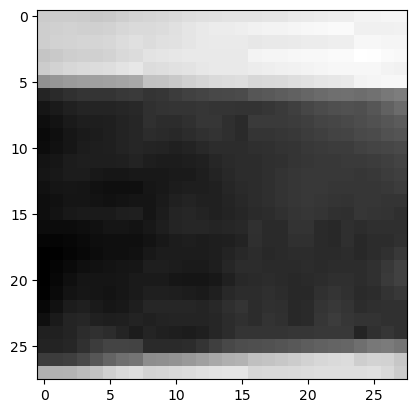

torch.Size([1, 28, 28])


In [41]:
temp_img1 = read_image('resized_img.jpg')

#show as greyscale
plt.imshow(temp_img1.permute(1, 2, 0), cmap='gray')
plt.show()

#print the dimensions of the image
print(temp_img1.shape)

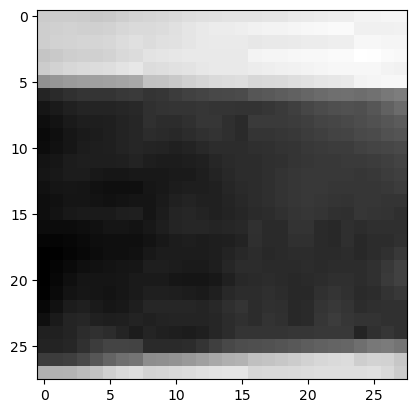

(28, 28)


In [47]:
#load temp_img as PIL image
temp_img21 = Image.open('resized_img.jpg')

#display the image
plt.imshow(temp_img21, cmap='gray')
plt.show()

#print dimensions of the image
print(temp_img21.size)

<class 'PIL.Image.Image'>
<class 'torch.Tensor'>


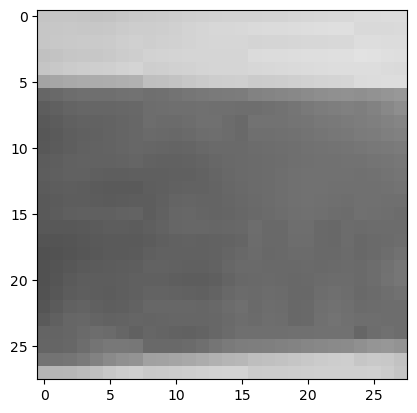

<built-in method size of Tensor object at 0x7f4b16202590>
torch.Size([3, 28, 28])


In [66]:
#load temp_img as PIL image
temp_img31 = Image.open('resized_img.jpg')

#make image color by adding 3 channels
temp_img31 = transforms.functional.to_grayscale(temp_img31, num_output_channels=3)

#print type
print(type(temp_img31))

#convert to `torch.Tensor`
temp_img31 = transforms.functional.to_tensor(temp_img31)
#print type
print(type(temp_img31))
#convert back to pil image
# temp_img31 = transforms.functional.to_pil_image(temp_img31)

#display the image
plt.imshow(temp_img31.permute(1, 2, 0))
plt.show()

#print dimensions of the image
print(temp_img31.size)

#print shape of the image
print(temp_img31.shape)


#### Step 1: Initialize model with the best available weights

In [9]:
#creating the model
weights = ResNet50_Weights.DEFAULT
#send weight sto gpu
# weights = weights.to(device)
#sending the model to GPU

model = resnet50(weights=weights).to(device)

In [10]:
#print model summary
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [13]:
#loop and check if there are batch norm layers
#use isinstance of BatchNorm2d
for layer in model.children():
    if isinstance(layer, nn.BatchNorm2d):
        print('yes')
        #print layer name
        print(layer)

yes
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


#### Step 2: Initialize the inference transforms

In [ ]:
temp_img3 = read_image('resized_img.jpg')

#show as greyscale
plt.imshow(temp_img3.permute(1, 2, 0), cmap='gray')
plt.show()

#print the dimensions of the image
print(temp_img3.shape)

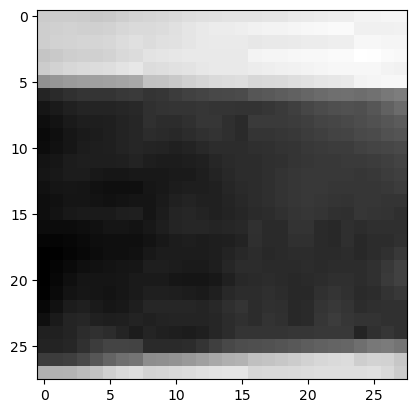

torch.Size([1, 28, 28])


In [69]:
temp_img_4 = read_image('resized_img.jpg')

#show as greyscale
plt.imshow(temp_img_4.permute(1, 2, 0), cmap='gray')
plt.show()

#print the dimensions of the image
print(temp_img_4.shape)

In [15]:
preprocess = weights.transforms()
#add on more transform to make channels 3 if there are only 1 channel
# preprocess.transforms.append(transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


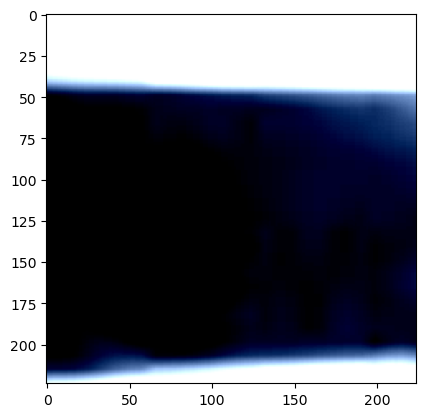

In [35]:
#appy preprocess to the temp_img
#make 3 channels
# temp_img_3 = 
# make 3 channels then apply preprocess
temp_img_3 = transforms.functional.to_grayscale(temp_img2, num_output_channels=3)
temp_img = preprocess(temp_img_3)
# print the dimensions of the image
print(temp_img.shape)

#show the image
plt.imshow(temp_img.permute(1, 2, 0))
plt.show()

In [67]:
# #define the transfrom for dataset
# transform = transforms.Compose([
#     #us ethe preprocess transform
#     # preprocess,
#     #reshape to 224x224 and preserve the channel
#     #if it is 1 channel then repeat it 3 times
#     transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
#     #resize to 224x224x3
#     transforms.Resize((224, 224)),
#     # transforms.Resize((224, 224)),
#     #now if channels are 1 then convert them to 3
#     # transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
#     #convert to tensor
#     transforms.ToTensor()
# ])
#define transform to be suitable for resnet50 input size
# transform = transforms.Compose([
#     #do not use the preprocess transform
#     # preprocess,
#     #read the image
#     # read_image,
#     #resize to 224x224x3
#     transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
#     transforms.Resize(IMAGE_SIZE),
#     #now if channels are 1 then convert them to 3
    
#     #convert to tensor
#     transforms.ToTensor(),
#     transforms.Normalize(
#             [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
#         ),
# ])

transform_resnet = transforms.Compose(
    [
    #if greyscale
    # if x.shape[0] == 1:
    #if greyscale then convert to 3 channels using , transforms.functional.to_grayscale( num_output_channels=3)
    # transforms.functional.to_grayscale( num_output_channels=3),
    #to tensor
    # transforms.ToTensor(),
    #if already torch tensor, then leave as it is ,else convert to tensor
    transforms.Lambda(lambda x: x if isinstance(x, torch.Tensor) else transforms.functional.to_tensor(x)),

    
        transforms.Resize(IMAGE_SIZE),
        # transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
        #if greyscale
        # transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),
    ]
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


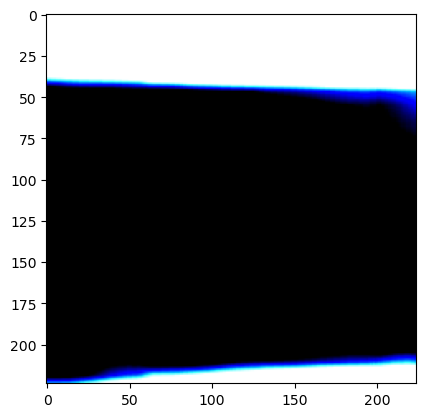

In [37]:
#apply preprocess to the temp_img
temp_img = preprocess(temp_img)
# print the dimensions of the image
print(temp_img.shape)

#show the image
plt.imshow(temp_img.permute(1, 2, 0))
plt.show()


In [64]:
#aaply transform to the temp_img2
temp_img21_transform = transform_resnet(temp_img21)
# print the dimensions of the image
print(temp_img21.shape)

#show the image
plt.imshow(temp_img21.permute(1, 2, 0))
plt.show()


RuntimeError: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]

torch.Size([3, 28, 28])


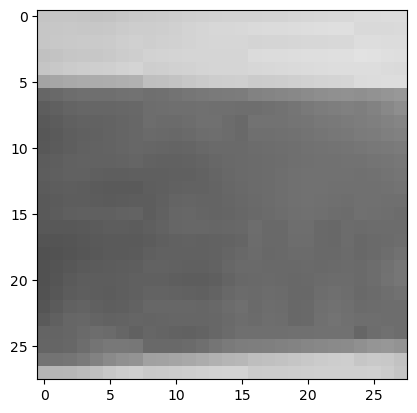

In [68]:
#aaply transform to the temp_img2
temp_img31_transform = transform_resnet(temp_img31)
# print the dimensions of the image
print(temp_img31.shape)

#show the image
plt.imshow(temp_img31.permute(1, 2, 0))
plt.show()


In [181]:
#define the transform for the dataset
transform_mnist_resnet = transforms.Compose(
    [
    #convert to pil image
    # transforms.ToPILImage(),
    #check if PIL Image then leave as it is, else convert to PIL Image
    # transforms.Lambda(lambda x: x if isinstance(x, Image.Image) else transforms.functional.to_pil_image(x)),
    # #if greyscale then convert to 3 channels using , transforms.functional.to_grayscale( num_output_channels=3)
    # #only if the image is greyscale, then convert to 3 channels, else leave as it is
    # transforms.Lambda(lambda x: transforms.functional.to_grayscale(x, num_output_channels=3) if x.shape[0] == 1 else x),

    #print type of image
    # transforms.Lambda(lambda x: print(type(x))),
    # resize to 224x224
    # transforms.Resize(IMAGE_SIZE),

    #apply preprocess transform
    # preprocess,
    #apply : preprocess = weights.transforms()
    #apply preprocess to input image
    # transforms.Lambda(lambda x: preprocess(x)),


    



    

    # if torch tensor then leave as it is, else convert to tensor
    transforms.Lambda(lambda x: x if isinstance(x, torch.Tensor) else transforms.functional.to_tensor(x)),
    #

    #resize to 224x224
    transforms.Resize(IMAGE_SIZE),

    #check if channels are 1, then convert to 3 channels
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x),

    transforms.Lambda(lambda x: preprocess(x)),
    
    # normalize
    transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

torch.Size([1, 28, 28])


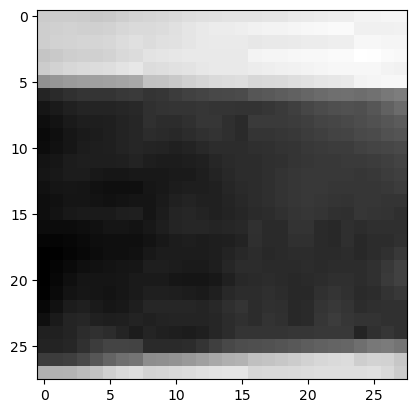

In [182]:
#load as read_image
temp_img_mnist = read_image('resized_img.jpg')

# print the dimensions of the image
print(temp_img_mnist.shape)

#show the image
plt.imshow(temp_img_mnist.permute(1, 2, 0) , cmap='gray')
plt.show()

(28, 28)


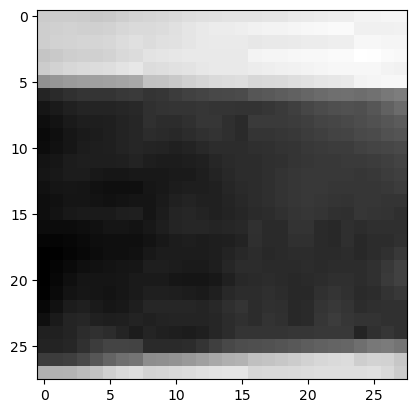

In [183]:
#load temp_img_mnist2 as PIL Image
temp_img_mnist2 = Image.open('resized_img.jpg')

# print the dimensions of the image
# print(temp_img_mnist2.shape)
#print dimensions
print(temp_img_mnist2.size)

#show the image
plt.imshow(temp_img_mnist2 , cmap='gray')
plt.show()

In [185]:
#apply transform to temp_img_mnist2
temp_img_mnist2_transform = transform_mnist_resnet(temp_img_mnist2)

#print type
print(type(temp_img_mnist2_transform))
#convert to tensor
# temp_img_mnist2_transform = transforms.functional.to_tensor(temp_img_mnist2_transform)
# print the dimensions of the image
print(temp_img_mnist2_transform.shape)

#show the image
# plt.imshow(temp_img_mnist2_transform.permute(1, 2, 0) )

# plt.show()


<class 'torch.Tensor'>
torch.Size([3, 224, 224])


In [127]:
#tes the transform
temp_img_mnist_transform = transform_mnist_resnet(temp_img_mnist)
# print the dimensions of the image


torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


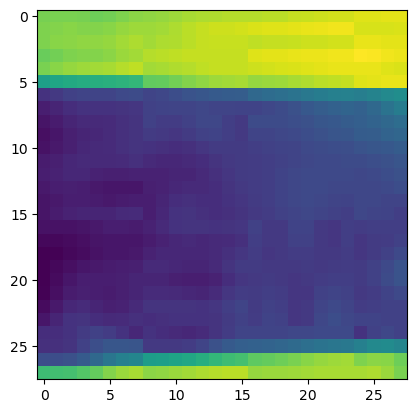

In [130]:
#print the dimensions of the image
print(temp_img_mnist_transform.shape)

#print size
print(temp_img_mnist_transform.size())

#show the image
plt.imshow(temp_img_mnist_transform.permute(1, 2, 0))
plt.show()

In [129]:
# #loop through the dataloader and print dimensions of first image and show the image and break
# for batch_idx, (data, target) in enumerate(train_loader):
#     #print type of data
#     # print(type(data))
#     # # print(data.shape)
#     # plt.imshow(data[0].permute(1, 2, 0))
#     # plt.show()
#     break

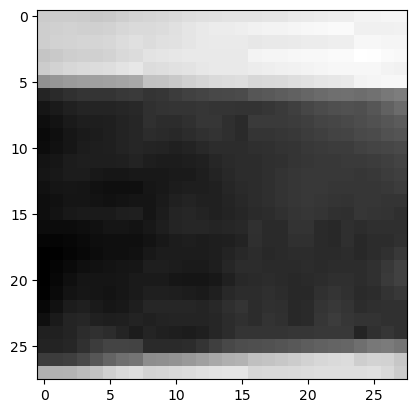

(28, 28)


In [87]:
#load temp_img as PIL image
temp_img41 = Image.open('resized_img.jpg')

#display the image
plt.imshow(temp_img41, cmap='gray')
plt.show()

#print dimensions of the image
print(temp_img41.size)

In [88]:
#test the transform on the image
temp_img41_transform = transform_mnist_resnet(temp_img41)


RuntimeError: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]

In [72]:
#test the ransform on temp_img_4
temp_img_4_transform = transform_mnist_resnet(temp_img_4)


TypeError: Input should be PIL Image

#### Dataset

In [103]:
#define the transform for the dataset
transform = transforms.Compose(
    [
    #convert to pil image
    # transforms.ToPILImage(),
    #check if PIL Image then leave as it is, else convert to PIL Image
    transforms.Lambda(lambda x: x if isinstance(x, Image.Image) else transforms.functional.to_pil_image(x)),

    # #resize to 224x224
    # transforms.Resize(IMAGE_SIZE),

    #if grayscale then convert to 3 channels using , transforms.functional.to_grayscale( num_output_channels=3)
    transforms.Lambda(lambda x: transforms.functional.to_grayscale(x, num_output_channels=3) if x.shape[0] == 1 else x),

    #if torch tensor then leave as it is, else convert to tensor
    transforms.Lambda(lambda x: x if isinstance(x, torch.Tensor) else transforms.functional.to_tensor(x)),

    #normalize
    transforms.Normalize(
        
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)



In [104]:
# for training we will use MNIST dataset in pytorch library
#for testing we will use USPS dataset

#### train data - MNIST

In [186]:
#load train data
train_data = datasets.MNIST(root='./data/', download=True, transform=transform_mnist_resnet) 
#load train data
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [187]:

#load test data
#USPS dataset
test_data = datasets.USPS(root='./data/', download=True, transform=set_matplotlib_close)


#load test data
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)



NameError: name 'set_matplotlib_close' is not defined

In [188]:
#print the length of train and test data
print(len(train_data))
#print the shape of train data
print(train_data[0][0].shape)
#print label of train data
print(train_data[0][1])

60000
torch.Size([3, 224, 224])
5


In [ ]:
#get the size of the train data and test data
train_size = len(train_data)
test_size = len(test_data)
#print
print('Train size: ', train_size)
print('Test size: ', test_size)

Train size:  60000
Test size:  7291


In [ ]:
#print shape of the data
print('Train data shape: ', train_data.data.shape)

Train data shape:  torch.Size([60000, 28, 28])


In [ ]:
#get the size of images in train and test data
# train_image_size = train_data.data.shape
# test_image_size = test_data[0][0].size()
#print
# print('Train image size: ', train_image_size)
# print('Test image size: ', test_image_size)
# train_size  = train_data.data.shape()
# print('Train image size: ', train_size)

In [ ]:
#iterate through the dataset and print the dimensions of first image and then use break
for i, (images, labels) in enumerate(train_loader):
    # print('Train image size: ', images[0].size())
    # print(images.size())
    # print(labels.size())
    break

AttributeError: shape